# EQBSCQ: Experimental Quantum Battle of the Sexes: Classical & Quantum

## 1. Installation of libraries

In [ ]:
!pip install -U -c https://qisk.it/1-0-constraints \
    qiskit==2.0.1 \
    qiskit-aer==0.17.0 \
    qiskit-ibm-runtime==0.39.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.3 MB/s eta 0:00:00


## 2. Imports and versions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time
import qiskit, qiskit_aer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from collections import defaultdict
import networkx as nx

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.transpiler import Layout
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts

from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)

from google.colab import files
import time
import pandas as pd
from tabulate import tabulate

print("== Libraries and versions ==") # == Librerías y versiones ==
print(f" qiskit     : {qiskit.__version__}")
print(f" aer        : {qiskit_aer.__version__}")
print(f" numpy      : {np.__version__}")
print(f" matplotlib : {plt.matplotlib.__version__}\n")

== Librerías y versiones ==
 qiskit     : 2.0.1
 aer        : 0.17.0
 numpy      : 2.0.2
 matplotlib : 3.10.0



## 3. Connection to IBM Quantum Runtime

In [ ]:
# Save your token the first time (only if you haven't saved it yet): # Guarda tu token la primera vez (solo si no lo has guardado aún):
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="cf4c6ea5027fd576fbda2f58c7d06ef004e8dd5bc410dbc38efabd9556001e0b9a99789d7c187849c3be06a1ee822a239bc1905db11a005673638bce815f73c1"  # <<<––– Token: German
)
service = QiskitRuntimeService(channel="ibm_quantum")  # reads the saved token now # ya lee el token guardado

<ipython-input-4-2a626b8d2d19>:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")  # ya lee el token guardado


## 4. Classic game: Battle of the sexes

In [ ]:
classical = type(
    "ClassicalCoordinationGame", (), {
        "__init__": lambda self: setattr(
            self, "payoff",
            {(0,0):(3,2),(1,1):(2,3),(0,1):(0,0),(1,0):(0,0)}
        ),
        "mixed_equilibrium_payoffs": lambda self: (
            3*(3/5)*(2/5) + 2*((1-3/5)*(1-2/5)),
            2*(2/5)*(3/5) + 3*((1-2/5)*(1-3/5))
        )
    }
)()
EA_cl, EB_cl = classical.mixed_equilibrium_payoffs()

print(f"Pago esperado Alice: {EA_cl}")
print(f"Pago esperado Bob: {EB_cl}")

Pago esperado Alice: 1.2
Pago esperado Bob: 1.2


## 5. QuantumCoordGameRuntime Class

In [ ]:
class QuantumCoordGameRuntime:
    def __init__(self,
                 gamma=None,
                 shots=2048,
                 Strategy='I',
                 use_hardware=True,
                 use_multicrt=False,
                 Pairs=None,
                 Num_executions=None):
        self.shots = shots
        self.Strategy = Strategy
        self.use_multicrt = use_multicrt
        self.use_hardware = use_hardware
        self.qubits = []

        if use_multicrt:
            # Parameters for multicircuit (lists of alpha/beta) # Parámetros para multicircuito (listas de alpha/beta)
            self.Pairs = Pairs
            self.alpha, self.beta = [], []
            for g in np.linspace(0, np.pi, Num_executions):
                self.alpha.append(np.cos(g/2))
                self.beta.append(np.sin(g/2))
        else:
            # Simple entangled state # Estado entrelazado simple
            self.alpha = np.cos(gamma/2)
            self.beta  = np.sin(gamma/2)

        # Backend selection # Selección de backend
        if self.use_hardware:
            self.backend = service.least_busy(min_num_qubits=62, simulator=False)
            self.sampler = Sampler(mode=self.backend)
            self.sampler.options.default_shots = shots
        else:
            self.backend = AerSimulator()
            self.sampler = self.backend

    def _select_best_adjacent_qubits(self):
        if self.backend.coupling_map is None:
            return [0, 1]
        edges = self.backend.coupling_map.get_edges()
        cx_errors = {}
        for i, j in edges:
            props = self.backend.target.get("cx", {}).get((i, j), None)
            if props is not None:
                cx_errors[(i, j)] = props.error
        if not cx_errors:
            print("⚠️ No CX data found; defaulting to [0,1].") # ⚠️ No se encontraron datos de CX; usando [0,1] por defecto.
            return [0, 1]
        return list(min(cx_errors, key=cx_errors.get))

    def _build_circuit(self, gateA, gateB):
        if self.use_multicrt:
            qc = QuantumCircuit(len(self.Pairs)*2, len(self.Pairs)*2)
            for num, (q0, q1) in enumerate(self.Pairs):
                # 1) prepare entanglement on qubits [2*num,2*num+1] # 1) preparar entrelazamiento en qubits [2*num,2*num+1]
                qc.append(StatePreparation(
                    [self.alpha[num], 0, 0, self.beta[num]]),
                    [2*num, 2*num+1]
                )
                # 2) apply gates on that block # 2) aplicar puertas en ese bloque
                for gate, offset in ((gateA, 0), (gateB, 1)):
                    target = 2*num + offset
                    if gate == 'H':      qc.h(target)
                    elif gate == 'R(pi_4)': qc.ry(np.pi/4, target)
                    elif gate == 'R(pi)':   qc.ry(np.pi, target)
                    # 'I' does nothing # 'I' no hace nada
                # 3) measure that pair # 3) medir ese par
                qc.measure([2*num, 2*num+1], [2*num, 2*num+1])
        else:
            # single-pair
            self.qubits = self._select_best_adjacent_qubits()
            qc = QuantumCircuit(2, 2)
            qc.append(StatePreparation([self.alpha, 0, 0, self.beta]), [0, 1])
            for gate, idx in ((gateA, 0), (gateB, 1)):
                if gate == 'H':      qc.h(idx)
                elif gate == 'R(pi_4)': qc.ry(np.pi/4, idx)
                elif gate == 'R(pi)':   qc.ry(np.pi, idx)
            qc.measure([0, 1], [0, 1])

        return qc

    def _transpile(self, qc):
        if self.use_hardware and self.qubits:
            return transpile(
                qc,
                backend=self.backend,
                initial_layout=self.qubits,
                layout_method='sabre',
                routing_method='sabre',
                optimization_level=3
            )
        return transpile(qc, backend=self.backend)

    def analyze_entangled_pairs(self, result, circuit_index=0):
        all_counts = result[0].data.c.get_counts()
        analysis = {}
        for i, (q1, q2) in enumerate(self.Pairs):
            c1, c2 = 2*i, 2*i+1
            pair_counts = marginal_counts(all_counts, [c1, c2])
            counts = {'00':0,'01':0,'10':0,'11':0}
            counts.update(pair_counts)
            analysis[f'pair_{i}'] = {'qubits': (q1, q2), 'counts': counts}
        return analysis

    def payoffs(self):
        qc  = self._build_circuit(self.Strategy, self.Strategy)
        tqc = self._transpile(qc)

        if self.use_multicrt:
            job = self.sampler.run([tqc])
            res = job.result(timeout=600)
            return self.analyze_entangled_pairs(res)

        # single-circuit
        if self.use_hardware:
            job = self.sampler.run([tqc])
            res = job.result(timeout=600)
            counts = res[0].data.c.get_counts()
            total = sum(counts.values())
            p00 = counts.get('00',0)/total if total else 0
            p11 = counts.get('11',0)/total if total else 0
        else:
            res = self.sampler.run(tqc, shots=self.shots).result()
            counts = res.get_counts()
            p00 = counts.get('00',0)/self.shots
            p11 = counts.get('11',0)/self.shots

        EA  = 3*p00 + 2*p11
        EB  = 2*p00 + 3*p11
        Err = 1 - (p00 + p11)
        return EA, EB, Err

## 6. Architecture

In [ ]:
list_arq_127qb = [[0, 1], [3, 4], [6, 7], [9, 10], [12, 13], [18, 19], [21, 22],
 [24, 25], [27, 28], [30, 31], [37, 38], [40, 41], [43, 44], [46, 47], [49, 50],
  [56, 57], [59, 60], [62, 63], [65, 66], [68, 69], [75, 76], [78, 79], [81, 82],
   [84, 85], [87, 88], [94, 95], [97, 98], [100, 101], [103, 104], [106, 107],
    [113, 114], [116, 117], [119, 120], [122, 123], [125, 126]]

In [ ]:
list_par_qb = list_arq_127qb[:31]

## 7. γ sweep in simulator

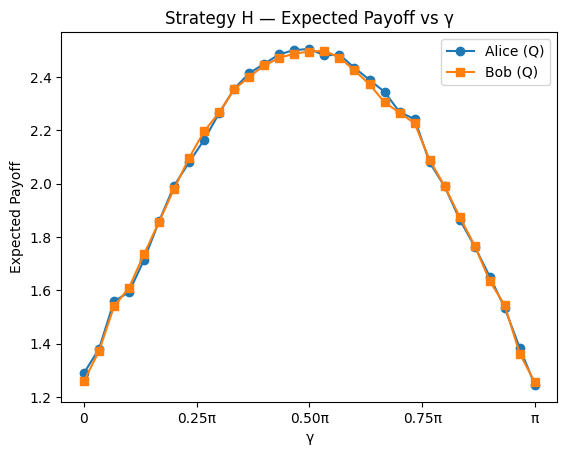

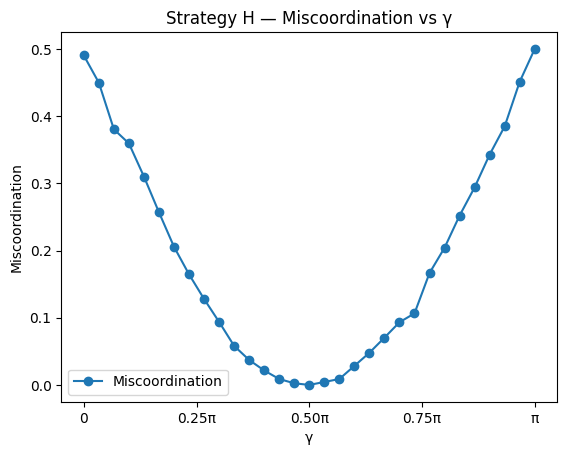

In [ ]:
# Only the 'H' strategy # Solo la estrategia 'H'
gammas = np.linspace(0, np.pi, 31)
strategy = 'H'

EA_qs, EB_qs, Err_qs = [], [], []

for g in gammas:
    game = QuantumCoordGameRuntime(
        gamma=g,
        shots=2048,
        Strategy=strategy,
        use_hardware=False,
        use_multicrt=False
    )
    EA, EB, Err = game.payoffs()
    EA_qs.append(EA)
    EB_qs.append(EB)
    Err_qs.append(Err)

# Function to format X-axis labels as multiples of π # Función para formatear etiquetas del eje X como múltiplos de π
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0): return "0"
    elif np.isclose(frac, 1): return "π"
    elif frac.is_integer(): return f"{int(frac)}π"
    else: return f"{frac:.2f}π"

# Payoff vs γ plot for H # Gráfico de Payoff vs γ para H
plt.figure()
plt.plot(gammas, EA_qs, '-o', label='Alice (Q)')
plt.plot(gammas, EB_qs, '-s', label='Bob (Q)')
plt.title(f'Strategy {strategy} — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend()

ax1 = plt.gca()
ax1.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax1.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
"""
path1 = "/content/drive/MyDrive/Works/Quantum/Code/Result/1_Strategie_H/Simulacion/0_Simulacion_Minimizada_strategy_H.png"
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] First image saved in: {path1}") # print(f"[✓] Primera imagen guardada en: {path1}")
"""
plt.show()   # ← shows the figure on screen # ← muestra la figura en pantalla
plt.close()

# Miscoordination vs γ plot for H # Gráfico de Descoordinación vs γ para H
plt.figure()
plt.plot(gammas, Err_qs, '-o', label='Miscoordination')
plt.title(f'Strategy {strategy} — Miscoordination vs γ')
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()

ax2 = plt.gca()
ax2.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax2.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
'''
path2 = "/content/drive/MyDrive/Works/Quantum/Code/Result/1_Strategie_H/Simulacion/1_Simulacion_Descoordinacion_Minimizada_strategy_H.png"
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Second image saved in: {path2}") # print(f"[✓] Segunda imagen guardada en: {path2}")
'''
plt.show()   # ← shows the figure on screen # ← muestra la figura en pantalla
plt.close()

## 8. Execution on real hardware

In [ ]:
def calcular_promedios_distribuidos(lista_datos, grupos=31):
    promedios = []
    for i in range(grupos):
        # We select the elements of group i: i, i+31, i+62, etc. # Seleccionamos los elementos del grupo i: i, i+31, i+62, etc.
        elementos_grupo = lista_datos[i::grupos]
        # We calculate the average of the group # Calculamos el promedio del grupo
        promedio = sum(elementos_grupo) / len(elementos_grupo)
        promedios.append(promedio)
    return promedios
def calcular_varianza_desviacion_distribuidos(lista_datos, promedio, grupos=31):
    varianza = []
    desviacion = []
    for i in range(grupos):
        # We select the elements of group i: i, i+31, i+62, etc. # Seleccionamos los elementos del grupo i: i, i+31, i+62, etc.
        elementos_grupo = lista_datos[i::grupos]
        # We calculate the variance of the group # Calculamos la varianza del grupo
        varianza_grupo = sum((x - promedio[i]) ** 2 for x in elementos_grupo) / (len(elementos_grupo) - 1)
        varianza.append(varianza_grupo)
        desviacion_grupo = varianza_grupo ** 0.5
        desviacion.append(desviacion_grupo)
    return varianza, desviacion

In [ ]:
P00.clear()
P01.clear()
P10.clear()
P11.clear()
times_real.clear()
list_par_qb_min_err.clear()
multicrt.clear()

In [ ]:
Intent = 5

In [ ]:
strategy = 'H' # Strategy selection (H) # Elección de estrategía (H)
Num_exe = 31 # Number of executions # Número de ejecuciones
P00, P01, P10, P11 = [], [], [], [] # Lists where data will be stored # Listas donde se van a guardar los datos
times_real = []
list_par_qb_min_err = []
for par_init in range(Num_exe):
    for i in range(par_init, par_init + len(list_par_qb)):
        list_par_qb_min_err.append(list_par_qb[i % len(list_par_qb)]) # Error minimization strategy per iteration # Estrategía de minimización de errores por iteración
    start_real = time.time()
    multicrt = QuantumCoordGameRuntime( # We define the multiple quantum circuit # Definimos el circuito cuántico múltiple
        shots=2048,
        use_hardware=True,
        use_multicrt=True,
        Pairs=list_par_qb_min_err,
        Num_executions=Num_exe,
        Strategy=strategy
    ).payoffs()
    elapsed = time.time() - start_real
    times_real.append(elapsed)
    for j in range(Num_exe): # We iterate over all pairs for each iteration for error minimization # Iteramos sobre todos los pares por cada iteración para minimización de errores
            counts = multicrt[f'pair_{j}']['counts']
            P00.append(multicrt[f'pair_{j}']['counts'].get("00", 0) / 2048)
            P01.append(multicrt[f'pair_{j}']['counts'].get("01", 0) / 2048)
            P10.append(multicrt[f'pair_{j}']['counts'].get("10", 0) / 2048)
            P11.append(multicrt[f'pair_{j}']['counts'].get("11", 0) / 2048)
    list_par_qb_min_err.clear()

In [ ]:
# Average value calculation # Cálculo valores promedio
P00_prom = calcular_promedios_distribuidos(P00, grupos=Num_exe)
P01_prom = calcular_promedios_distribuidos(P01, grupos=Num_exe)
P10_prom = calcular_promedios_distribuidos(P10, grupos=Num_exe)
P11_prom = calcular_promedios_distribuidos(P11, grupos=Num_exe)
# Variance and Standard Deviation Calculation # Cálculo Varianza y Desviación Estándar
P00_var, P00_desv = calcular_varianza_desviacion_distribuidos(P00, P00_prom, grupos=Num_exe)
P01_var, P01_desv = calcular_varianza_desviacion_distribuidos(P01, P01_prom, grupos=Num_exe)
P10_var, P10_desv = calcular_varianza_desviacion_distribuidos(P10, P10_prom, grupos=Num_exe)
P11_var, P11_desv = calcular_varianza_desviacion_distribuidos(P11, P11_prom, grupos=Num_exe)

In [ ]:
EA_real, EB_real, Err_EA_real, Err_EB_real = [], [], [], []
Miscoord_real, Err_Miscoord_real = [], []
for i in range(Num_exe):
    # Real payoff calculation # Cálculo de pagos reales
    EA_real.append(P00_prom[i] * 3 + P11_prom[i] * 2)
    EB_real.append(P00_prom[i] * 2 + P11_prom[i] * 3)
    # Real error propagation calculation # Cálculo de propagación de errores reales
    Err_EA_real.append(np.sqrt((3 * P00_desv[i] / np.sqrt(Num_exe))**2 + (2 * P11_desv[i] / np.sqrt(Num_exe))**2))
    Err_EB_real.append(np.sqrt((2 * P00_desv[i] / np.sqrt(Num_exe))**2 + (3 * P11_desv[i] / np.sqrt(Num_exe))**2))
    # Miscoordination calculation # Cálculo de descoordinación
    Miscoord_real.append(P01_prom[i] + P10_prom[i])
    # Error propagation calculation # Cálculo de propagación de errores
    Err_Miscoord_real.append(np.sqrt((P01_desv[i] / np.sqrt(Num_exe))**2 + (P10_desv[i] / np.sqrt(Num_exe))**2))

## 9. Result Graphs

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/Real/0_Real_Minimizada_strategy_H.png


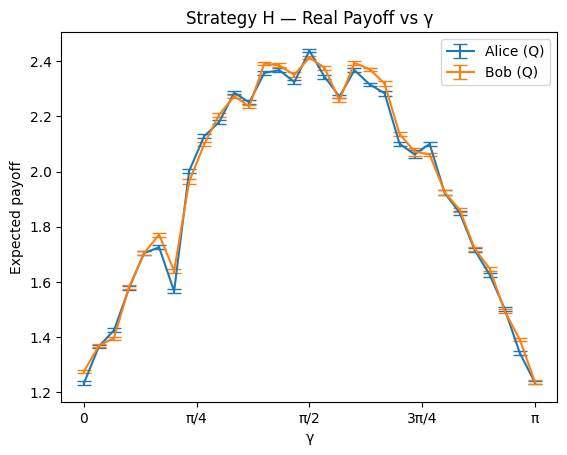

In [ ]:
# --- Figure 1: Real Payoff vs γ --- # --- Figura 1: Payoff Real vs γ ---
fig3 = plt.figure()
plt.errorbar(gammas, EA_real, yerr=Err_EA_real, fmt='-', capsize=5, label='Alice (Q)')
plt.errorbar(gammas, EB_real, yerr=Err_EB_real, fmt='-', capsize=5, label='Bob (Q)')
plt.title("Strategy H — Real Payoff vs γ")
plt.xlabel("γ")
plt.ylabel("Expected payoff")
plt.legend()

# Configure X-axis with multiples of π # Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4 # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_payoff = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/Real/0_Real_Minimizada_strategy_H.png"
os.makedirs(os.path.dirname(path_payoff), exist_ok=True)
plt.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved in: {path_payoff}") # print(f"[✓] Payoff real guardado en: {path_payoff}")

plt.show()
plt.close(fig3)

[✓] Descoordinación real guardada en: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/Real/1_Descoordinacion_Minimizada_strategy_H.png


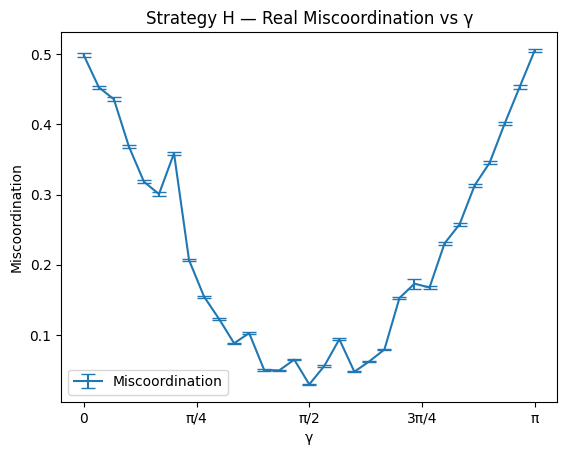

In [ ]:
# --- Figure 2: Real Miscoordination vs γ --- # --- Figura 2: Descoordinación Real vs γ ---
fig4 = plt.figure()
plt.errorbar(gammas, Miscoord_real, yerr=Err_Miscoord_real, fmt='-', capsize=5, label='Miscoordination')
plt.title("Strategy H — Real Miscoordination vs γ")
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()

# Configure X-axis with multiples of π # Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4 # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_descoord = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/Real/1_Descoordinacion_Minimizada_strategy_H.png"
fig4.savefig(path_descoord, dpi=300, bbox_inches='tight')
print(f"[✓] Real miscoordination saved in: {path_descoord}") # print(f"[✓] Descoordinación real guardada en: {path_descoord}")

plt.show()
plt.close(fig4)

[✓] Varianza guardada en: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/Real/2_Varianza_Minimizada_strategy_H.png


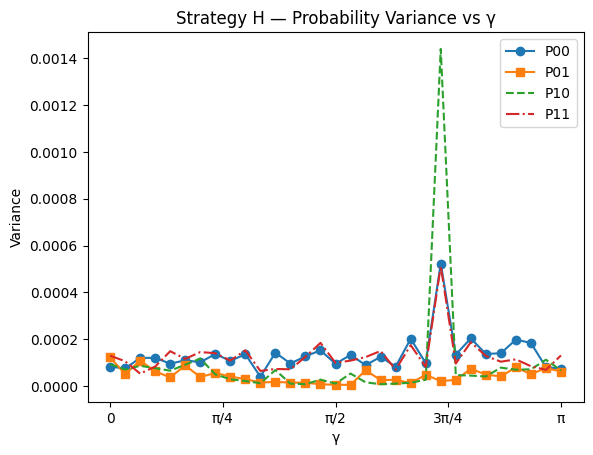

In [ ]:
# --- Figure 3: Probability variance vs γ --- # --- Figura 3: Varianza de probabilidades vs γ ---
fig5 = plt.figure()
plt.plot(gammas, P00_var, '-o', label='P00')
plt.plot(gammas, P01_var, '-s', label='P01')
plt.plot(gammas, P10_var, '--', label='P10')
plt.plot(gammas, P11_var, '-.', label='P11')
plt.title("Strategy H — Probability Variance vs γ")
plt.xlabel("γ")
plt.ylabel("Variance")
plt.legend()

# Configure X-axis with multiples of π # Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4 # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_var = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/Real/2_Varianza_Minimizada_strategy_H.png"
fig5.savefig(path_var, dpi=300, bbox_inches='tight')
print(f"[✓] Variance saved in: {path_var}") # print(f"[✓] Varianza guardada en: {path_var}")

plt.show()
plt.close(fig5)

# 10. Comparison

In [ ]:
# Create the DataFrame # Crear el DataFrame
df_comp = pd.DataFrame({
    'strategy':      [strategy] * Num_exe,
    'γ':             list(np.linspace(0, np.pi, Num_exe)),
    'EA_sim':        EA_qs[:Num_exe],
    'EA_real':       EA_real,
    'ΔEA':           [s - r for s, r in zip(EA_qs[:Num_exe], EA_real)],
    'Err_EA_real':   Err_EA_real,
    'EB_sim':        EB_qs[:Num_exe],
    'EB_real':       EB_real,
    'ΔEB':           [s - r for s, r in zip(EB_qs[:Num_exe], EB_real)],
    'Err_EB_real':   Err_EB_real,
    'Mis_sim':       Err_qs[:Num_exe],
    'Mis_real':      Miscoord_real,
    'ΔMis':          [s - r for s, r in zip(Err_qs[:Num_exe], Miscoord_real)],
    'Err_Mis_real':  Err_Miscoord_real,
    'Var_P00':       P00_var,
    'Var_P01':       P01_var,
    'Var_P10':       P10_var,
    'Var_P11':       P11_var,
    'Time_real_s':   times_real
})

output_csv = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/CSV/tabla_strategy_H.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df_comp.to_csv(output_csv, index=False)
print(f"[✓] CSV saved at: {output_csv}")
print(tabulate(df_comp, headers='keys', tablefmt='fancy_grid', showindex=False))

[✓] CSV saved at: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/CSV/tabla_strategy_H.csv
╒════════════╤══════════╤══════════╤═══════════╤════════════╤═══════════════╤══════════╤═══════════╤══════════════╤═══════════════╤════════════╤════════════╤═════════════╤════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═══════════════╕
│ strategy   │        γ │   EA_sim │   EA_real │        ΔEA │   Err_EA_real │   EB_sim │   EB_real │          ΔEB │   Err_EB_real │    Mis_sim │   Mis_real │        ΔMis │   Err_Mis_real │     Var_P00 │     Var_P01 │     Var_P10 │     Var_P11 │   Time_real_s │
╞════════════╪══════════╪══════════╪═══════════╪════════════╪═══════════════╪══════════╪═══════════╪══════════════╪═══════════════╪════════════╪════════════╪═════════════╪════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═══════════════╡
│ H          │ 0        │  1.28955 │   1.23234 │  0.0572077 │    0.00640675 │  1.25928 │   1.27467 │ -0.0153887   │

## 11. Histogram of absolute errors

[✓] EA comparison chart saved at: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/CSV/bar_EA_sim_vs_real_strategy_H.png


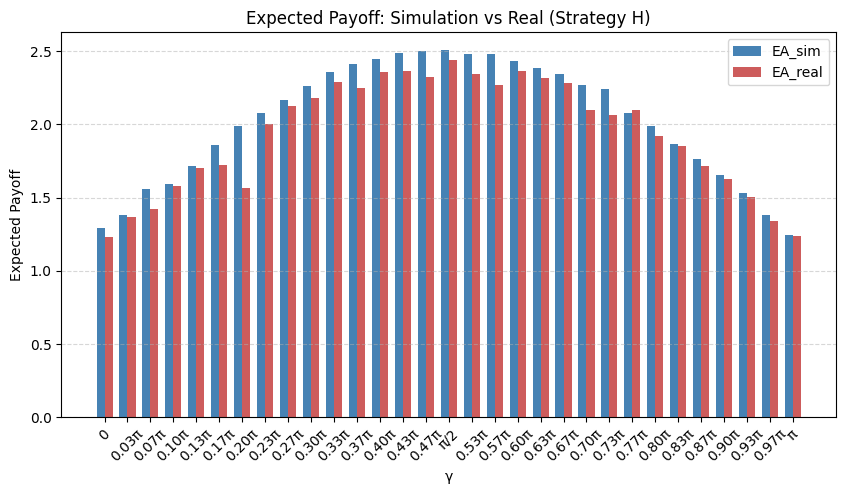

[✓] Miscoordination comparison chart saved at: /content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/5/CSV/bar_Mis_sim_vs_real_strategy_H.png


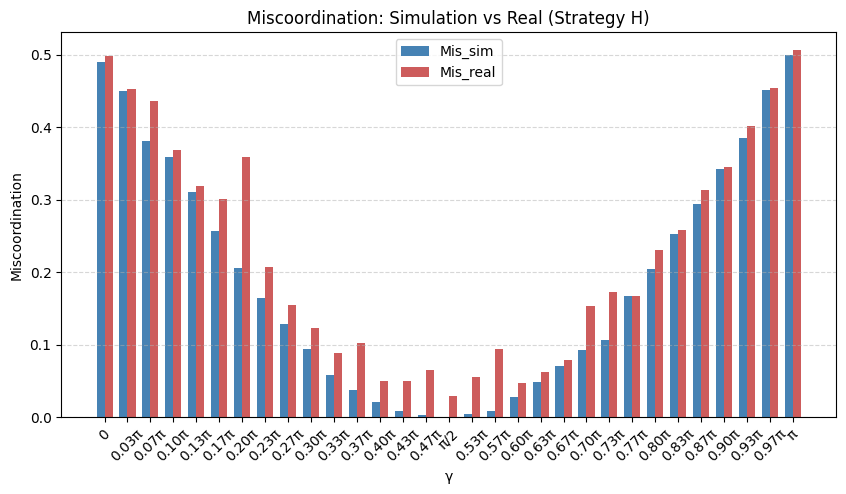

In [ ]:
gammas = df_comp['γ'].values
EA_sim = df_comp['EA_sim'].values
EA_real = df_comp['EA_real'].values
Mis_sim = df_comp['Mis_sim'].values
Mis_real = df_comp['Mis_real'].values

# Positions for the bars # Posiciones para las barras
indices = np.arange(len(gammas))
width   = 0.35

# π Formatter # Formatter de π
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0):      return "0"
    elif np.isclose(frac, 0.25): return "π/4"
    elif np.isclose(frac, 0.5):  return "π/2"
    elif np.isclose(frac, 0.75): return "3π/4"
    elif np.isclose(frac, 1.0):  return "π"
    else:                         return f"{frac:.2f}π"

# --- EA_sim vs EA_real plot --- # --- Gráfico de EA_sim vs EA_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, EA_sim,  width, label='EA_sim', color='steelblue')
ax.bar(indices + width/2, EA_real, width, label='EA_real', color='indianred')

ax.set_title("Expected Payoff: Simulation vs Real (Strategy H)")
ax.set_xlabel("γ")
ax.set_ylabel("Expected Payoff")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path1 = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/CSV/bar_EA_sim_vs_real_strategy_H.png"
os.makedirs(os.path.dirname(path1), exist_ok=True)
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] EA comparison chart saved at: {path1}")
plt.show()
plt.close()

# --- Mis_sim vs Mis_real plot --- # --- Gráfico de Mis_sim vs Mis_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, Mis_sim,  width, label='Mis_sim', color='steelblue')
ax.bar(indices + width/2, Mis_real, width, label='Mis_real', color='indianred')

ax.set_title("Miscoordination: Simulation vs Real (Strategy H)")
ax.set_xlabel("γ")
ax.set_ylabel("Miscoordination")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path2 = f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/{Intent}/CSV/bar_Mis_sim_vs_real_strategy_H.png"
os.makedirs(os.path.dirname(path2), exist_ok=True)
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Miscoordination comparison chart saved at: {path2}")
plt.show()
plt.close()